In [6]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import jax
import numpy as np

from sde4mbrlExamples.rotor_uav.sde_rotor_model import load_predictor_function, load_trajectory

%matplotlib widget
import matplotlib.pyplot as plt

# Magic IPython deepreloading...
%reload_ext autoreload
%autoreload 2
import builtins
from IPython.lib import deepreload
builtins.reload = deepreload.reload

%autoreload

In [31]:
# Path for the learned sde parameters
sde_path = '/home/franckdjeumou/Documents/sde4mbrl/sde4mbrlExamples/rotor_uav/iris_sitl/my_models/hexa_lin_highhighnoise_full_sde_params.pkl'
# Load some data to try the model on
# path_traj = '/home/franckdjeumou/Documents/log_flights/log_6_2022-10-25-14-03-16.ulg'
path_traj = '/home/franckdjeumou/Documents/log_flights/iris_sitl_test2.ulg'
_traj_x, _traj_u = load_trajectory(path_traj) # Only the first trajectory
traj_data = {'y' : _traj_x[0], 'u' : _traj_u[0]}

  0%|          | 0/10876 [00:00<?, ?it/s]

  0%|          | 0/10876 [00:00<?, ?it/s]

  0%|          | 0/10876 [00:00<?, ?it/s]

  0%|          | 0/10876 [00:00<?, ?it/s]

The length of the sequence is 5957 | Original = 10876


In [34]:
modified_params = {'horizon' : 50, 'num_particles' : 50}
# Create the nominal dynamics model
nominal_model = jax.jit(load_predictor_function(sde_path, prior_dist=True, nonoise=True, modified_params= modified_params))
# Create prior model
prior_model = jax.jit(load_predictor_function(sde_path, prior_dist=True, modified_params = modified_params))
# Create posterior model
posterior_model = jax.jit(load_predictor_function(sde_path, prior_dist=False, modified_params = modified_params))

In [35]:
def n_steps_analysis(xtraj, utraj, jit_sampling_fn, num_step = 1, num_shape = None, num_particles=100):
    # Initial random number generator
    rng = jax.random.PRNGKey(0)
    rng, s_rng = jax.random.split(rng)
    # Initial state
    xpred = [np.array([xtraj[0] for i in range(num_particles)])]
    # 
    num_iter = num_shape if num_shape is not None else utraj.shape[0]
    for i in range(0, num_iter, num_step):
        if i + num_step > num_iter:
            break
        rng, s_rng = jax.random.split(rng)
        xnext_pred = np.array(jit_sampling_fn(xtraj[i], utraj[i:i+num_step], s_rng))[:,1:,:]
        # Set the time in the first axis of the trajectory
        xpred.extend([xnext_pred[:,k,:] for k in range(xnext_pred.shape[1])])
    # Bundle everything in a numpy array
    xevol = np.array(xpred).reshape((-1,num_particles, xtraj.shape[1]))
    return xevol

In [36]:
# COmpute trajectory by the nominal model
xevol_nominal = n_steps_analysis(traj_data['y'], traj_data['u'], nominal_model, num_step = modified_params['horizon'], num_shape = None, num_particles=modified_params['num_particles'])

In [37]:
xevol_prior = n_steps_analysis(traj_data['y'], traj_data['u'], prior_model, num_step = modified_params['horizon'], num_shape = None, num_particles=modified_params['num_particles'])

In [38]:
xevol_posterior = n_steps_analysis(traj_data['y'], traj_data['u'], posterior_model, num_step = modified_params['horizon'], num_shape = None, num_particles=modified_params['num_particles'])

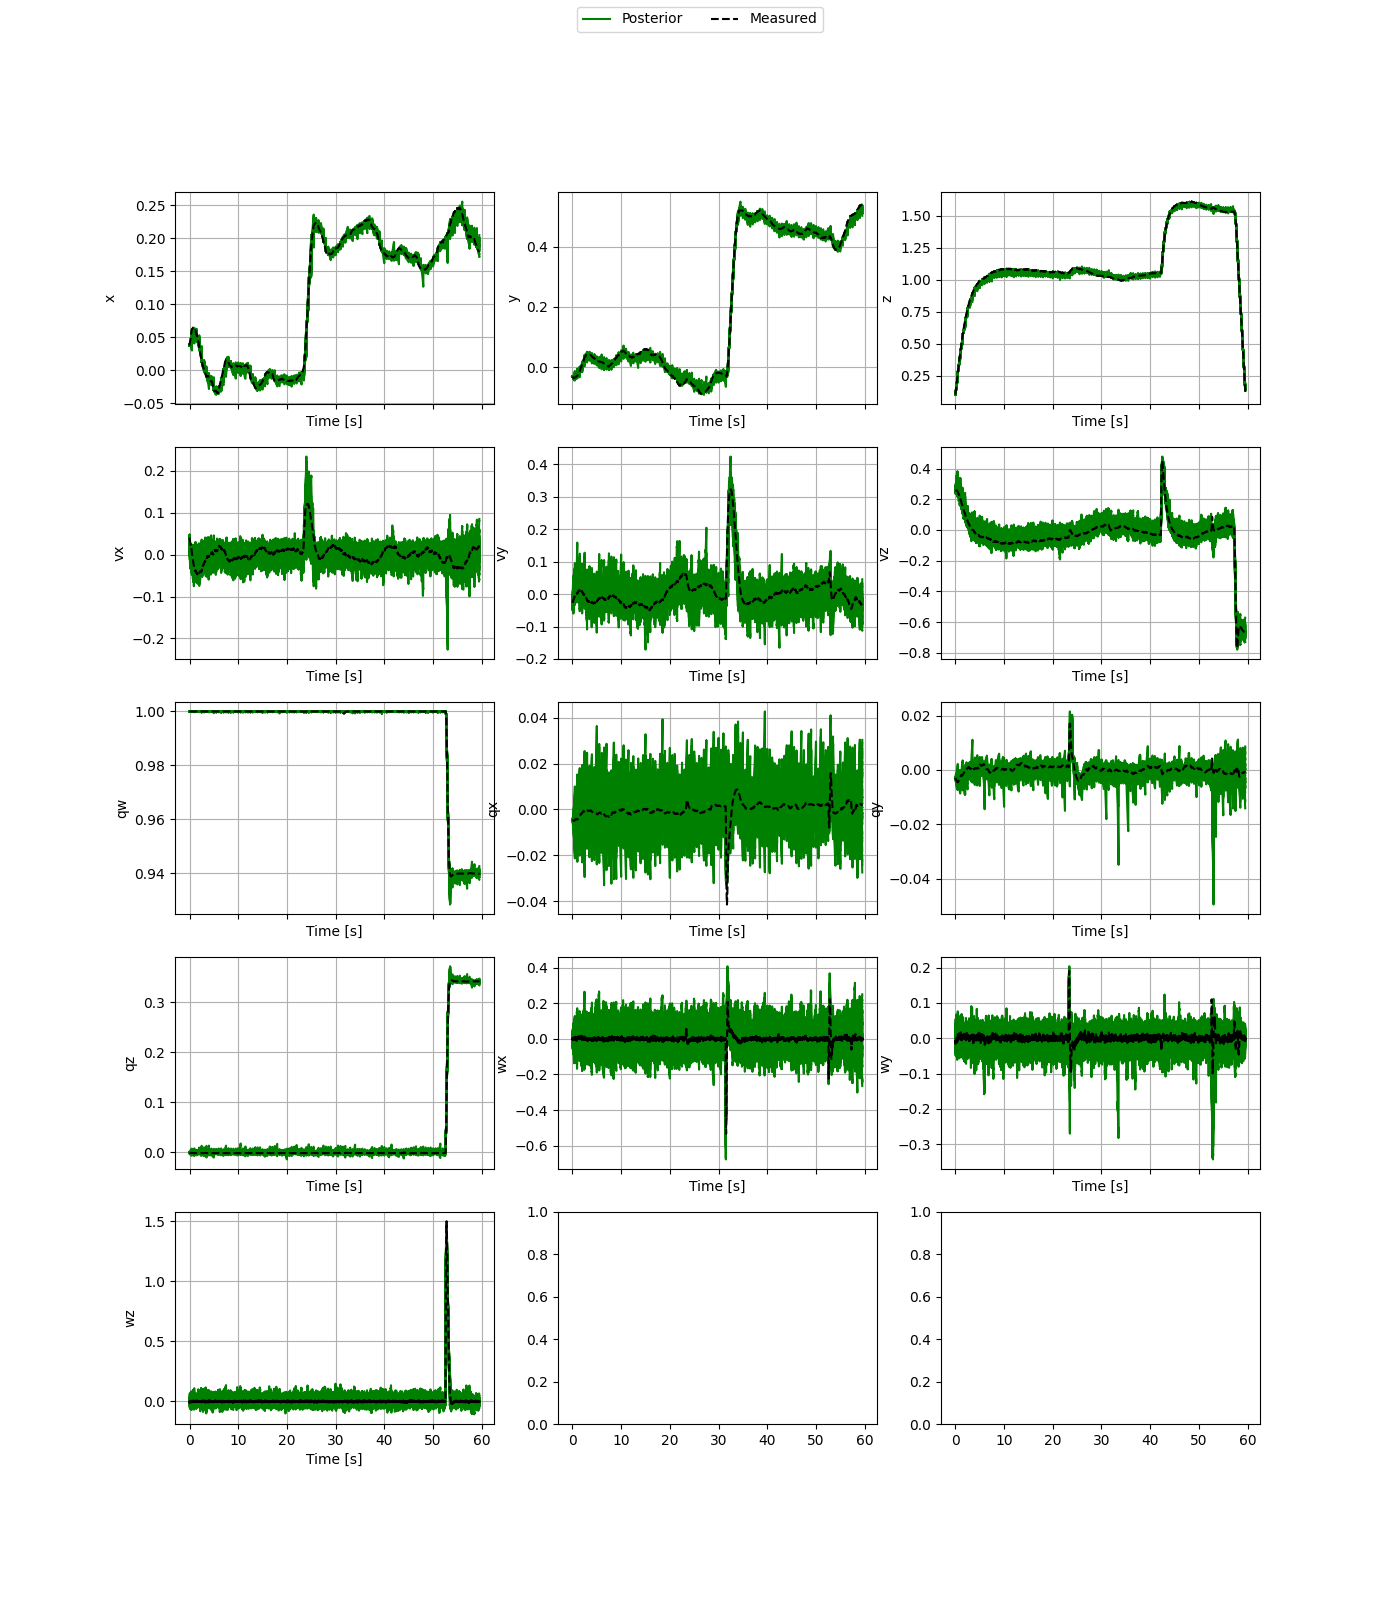

In [39]:
# The states in the x array
name_states = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'qw', 'qx', 'qy', 'qz', 'wx', 'wy', 'wz']
# num_sample_plot = 1
num_sample_plot = xevol_posterior.shape[1]
# True x trajectory
xtraj_true = traj_data['y']
time_evol = np.linspace(0, xtraj_true.shape[0]*0.01, xtraj_true.shape[0])
ash = xevol_nominal.shape[0]
# Let's plot all the state in the trajectory traj_data
fig, axs = plt.subplots(5,3, figsize=(14,16), sharex=True)
axs = axs.flatten()
for i in range(len(name_states)):
    # axs[i].plot(time_evol[:ash], xevol_prior[:,0,i], color='b', label='prior')
    for k in range(num_sample_plot):
        # axs[i].plot(time_evol[:ash], xevol_prior[:,k,i], color='b', label='prior' if k==0 else None)
        axs[i].plot(time_evol[:ash], xevol_posterior[:,k,i], color='g', label='Posterior' if k==0 else None)
    # axs[i].plot(time_evol[:ash], xevol_nominal[:,0,i], color='r', label='Nominal')
    axs[i].plot(time_evol, xtraj_true[:,i], color='k', linestyle='--', label='Measured')
    # axs[i].plot(xevol_prior[:,0,i], label='Prior')
    # axs[i].plot(xevol_posterior[:,0,i], label='Posterior')
    axs[i].set_ylabel(name_states[i])
    axs[i].set_xlabel('Time [s]')
    # axs[i].set_title(name_states[i])
    # axs[i].legend()
    axs[i].grid()

# Set a single legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5)